<a href="https://colab.research.google.com/github/snigdhashoily/ML_Lab/blob/main/SnigdhaAkterShoily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your vehicle type images
base_dir = '/content/drive/MyDrive/ML Lab Project/Vehicle Type Recognition'

In [ ]:
import cv2
import os
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing import image

SVM Accuracy: 0.39759036144578314
Confusion Matrix:
 [[13  9  6  2]
 [ 5  9  5  3]
 [ 6  1  1  3]
 [ 4  4  2 10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.43      0.45        30
           1       0.39      0.41      0.40        22
           2       0.07      0.09      0.08        11
           3       0.56      0.50      0.53        20

    accuracy                           0.40        83
   macro avg       0.37      0.36      0.36        83
weighted avg       0.41      0.40      0.41        83



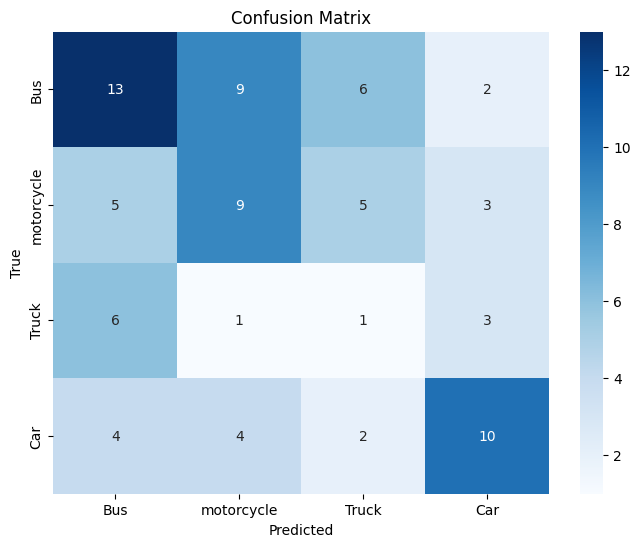

In [ ]:
#Code for Conventional Method (SVM)
import cv2
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import seaborn as sns

# Step 01: Image Preprocessing & Feature Extraction

# Function to extract HOG features from an image
def extract_hog_features(image):
    # Convert to grayscale (optional)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute HOG features and visualize them
    features, hog_image = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Improve the visual quality of the HOG image
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return features

# Function to extract color histogram features from an image
def extract_color_histogram(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate histograms for each channel (Hue, Saturation, Value)
    hist_hue = cv2.calcHist([hsv], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv], [2], None, [256], [0, 256])

    # Flatten and concatenate all three histograms
    hist_features = np.concatenate([hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()])

    return hist_features

# Function to load and preprocess images from a directory
def preprocess_images(image_dir, target_size=(224, 224)):
    images = []
    labels = []
    label_map = {label: index for index, label in enumerate(os.listdir(image_dir))}

    for label in os.listdir(image_dir):
        label_path = os.path.join(image_dir, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            img = cv2.imread(image_path)
            img = cv2.resize(img, target_size)
            # Extract features (HOG + Color Histogram)
            hog_features = extract_hog_features(img)
            color_histogram = extract_color_histogram(img)
            # Combine HOG features with color histogram features
            features = np.concatenate([hog_features, color_histogram])
            images.append(features)
            labels.append(label_map[label])

    return np.array(images), np.array(labels)

# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/ML Lab Project/Vehicle Type Recognition'  # Replace with the actual path to your dataset
X, y = preprocess_images(image_dir)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Step 02: Train an SVM model
svm_model = SVC(kernel='linear')  # You can experiment with other kernels like 'rbf'
svm_model.fit(X_train, y_train)
# Predict on test data
y_pred = svm_model.predict(X_test)

#Step 03: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy}")

#for result
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(image_dir), yticklabels=os.listdir(image_dir))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#code for CNN
# Image data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Use 20% of the data for validation

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 331 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 01: Image data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Consistent target_size
img_width, img_height = 224, 224

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Step 02: Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Found 331 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,399,174 (169.37 MB)

 Trainable params: 44,399,174 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#code for CNN
#Step 03: Replace with actual training data directory

train_dir = '/content/drive/MyDrive/ML Lab Project/Vehicle Type Recognition'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 411 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 411 images belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 490ms/step - accuracy: 0.2450 - loss: 1.9646
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 480ms/step - accuracy: 0.4614 - loss: 1.2130
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 484ms/step - accuracy: 0.7015 - loss: 0.8210
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - accuracy: 0.7604 - loss: 0.6248
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 489ms/step - accuracy: 0.8640 - loss: 0.4375
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 489ms/step - accuracy: 0.9165 - loss: 0.2378
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 493ms/step - accuracy: 0.9723 - loss: 0.1290
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 485ms/step - accuracy: 0.9926 - loss: 0.0436
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 487ms/step - accuracy: 0.9975 - loss: 0.0169
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 476ms/step - accuracy: 1.0000 - loss: 0.0072


Found 411 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 1.0000 - loss: 0.0037
Test Accuracy: 1.0


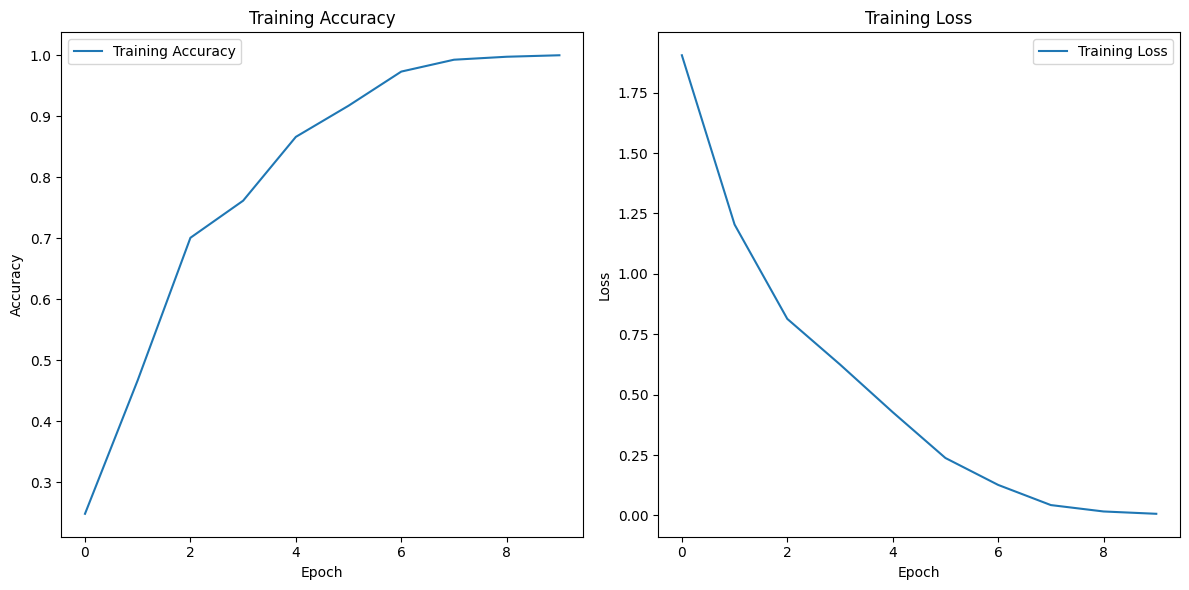

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Define CNN architecture for training
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),

    layers.Dense(4, activation='softmax')  # 4 classes: Bus, Car, Truck, Motorcycle
])

# Compile the CNN model using categorical cross-entropy for multi-class classification
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation and preprocessing for the training dataset
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
train_dir = '/content/drive/MyDrive/ML Lab Project/Vehicle Type Recognition'  # Adjust the path accordingly
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'  # Categorical for multi-class classification
)

# Step 4: Train the CNN model and capture the training history
history = cnn_model.fit(train_generator, epochs=10, steps_per_epoch=100)

# Save the trained model
cnn_model.save('vehicle_cnn_model.h5')

# Step 5: Evaluate the CNN model (on test data)
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_dir = '/content/drive/MyDrive/ML Lab Project/Vehicle Type Recognition'  # Adjust path accordingly
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical',  # Categorical for multi-class classification
    shuffle=False  # Important: Set shuffle=False for evaluation
)

# Evaluate the model performance on test data
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Step 6: Plot training accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Plot for training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Training accuracy
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot for training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')  # Training loss
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


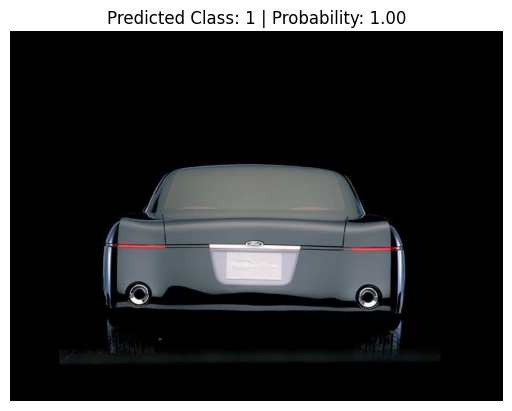

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


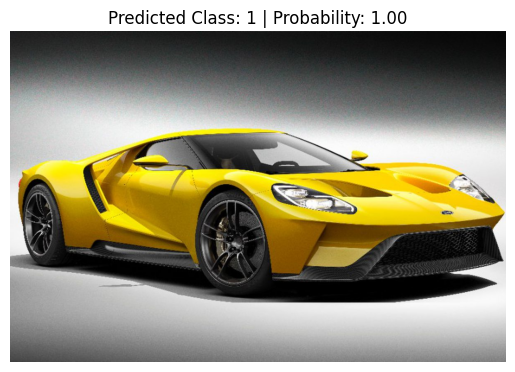

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


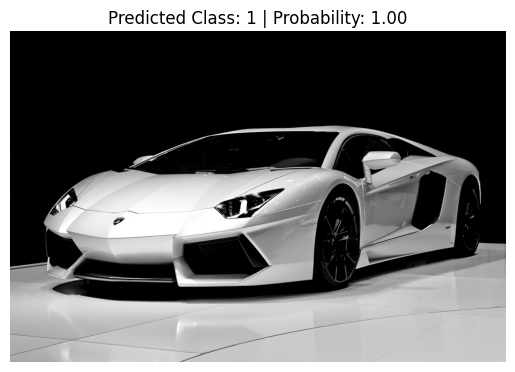

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


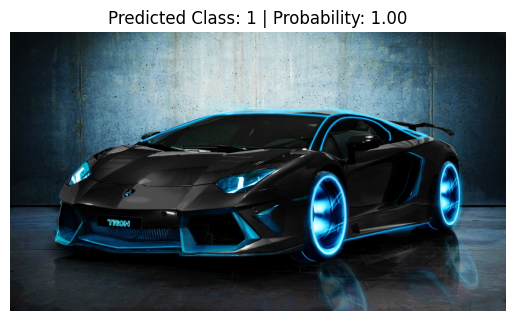

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


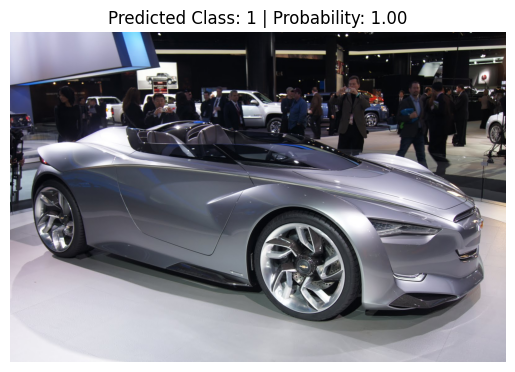

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


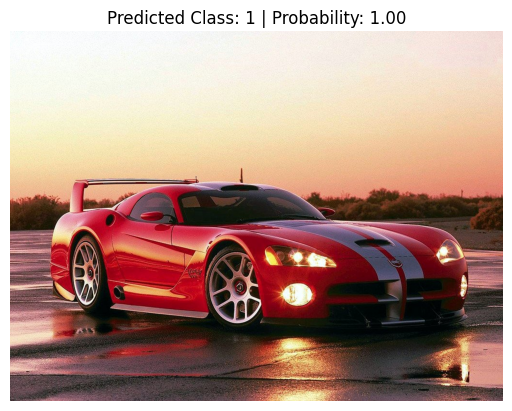

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the trained model
cnn_model = tf.keras.models.load_model('vehicle_cnn_model.h5')

# Preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Predict the class of a given image
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = cnn_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class, predictions

# Visualize the image and the prediction
def visualize_prediction(img_path, predicted_class, predictions):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted Class: {predicted_class[0]} | Probability: {np.max(predictions):.2f}") #add [0] in predicted_class
    plt.show()

# Example of making a prediction
test_img_path = '/content/drive/MyDrive/ML Lab Project/Vehicle Type Recognition/Car/Image_100.jpg'  # Replace with actual image path

# Get predicted class and the model's prediction probabilities
predicted_class, predictions = predict_image(test_img_path)

# Visualize the image and the prediction
visualize_prediction(test_img_path, predicted_class, predictions)

# If you want to visualize multiple images in a directory
test_dir = '/content/drive/MyDrive/ML Lab Project/Vehicle Type Recognition/Car'  # Replace with actual test directory path
image_files = os.listdir(test_dir)

for img_file in image_files[:5]:  # Show predictions for the first 5 images
    img_path = os.path.join(test_dir, img_file)
    predicted_class, predictions = predict_image(img_path)
    visualize_prediction(img_path, predicted_class, predictions)